2018 Aug 15<br>
This notebook contains the final, published analysis of the Kepler lightcurves for the Kepler-76 system. 

In [39]:
%matplotlib inline
import time as tm

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from copy import deepcopy

from astropy import units as u

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from numpy.random import normal

from PyAstronomy.modelSuite import forTrans as ft
from PyAstronomy.pyasl import isInTransit

from lightkurve import KeplerLightCurveFile

from evilmc import evparams, evmodel, convert_Kz
from transit_utils import median_boxcar_filter, bindata, transit_duration, flag_outliers, fit_eclipse_bottom
from variable_eclipses_utils import retreive_data

from scipy.signal import lombscargle

import dill

KIC = 4570949
#dill.load_session('Analysis_of_Kepler76b.db')

In [47]:
# The system parameters as reported in Faigler et al. (2013) --
#  http://iopscience.iop.org/article/10.1088/0004-637X/771/1/26/meta
a = 1./0.221 #± 0.003
b = 0.944 # ± 0.011
inc = 78.0 # ± 0.2
per = 1.54492875*u.day # ± 0.00000027
Kz_m_per_s = 308. # ± 20.
Kz = convert_Kz(Kz=Kz_m_per_s) # convert to fraction of the speed of light

Mp = 2.00*u.jupiterMass # ± 0.26
Rp_over_a = 0.0214 # ± 0.0008
Rp_over_Rs = Rp_over_a*a
Ms = 1.2*u.solMass # ± 0.2
q = (Mp.to('kg')/Ms.to('kg')).value

vsini = 6500.*u.m/u.s # ± 2000
Rs = 1.32*u.solRad #± 0.08
Omegas = vsini.to('m/s')/Rs.to('m')*per.to('s') # stellar rotation state - very little effect, so chosen arbitrarily

Ts = 6300. # ± 200
Faigler_T0 = (737.49 + 2455000. - 2454833.) % per.to('day').value # ±0.19
T0 = 0.68508434

coeffs = [0.313, 0.304]

Aplanet = 50.4e-6 # ± 2.0
F0 = 50.4e-6 # ± 2.0 -- overall shift in light curve, which is arbitrary
phase_shift = 10.3/360. # ± 2.0 - convert phase shift angle from degrees to orbital phase

beta = 0.0716671 # Interpolation from among the values reported in Claret & Bloemen (2011) A&A 529, 75

# Save parameters to an evilmc parameters object
saved_ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, limb_dark="quadratic", b=b, 
                    F0=F0, Aplanet=Aplanet, phase_shift=phase_shift, beta=beta, q=q, Kz=Kz, Ts=Ts, Ws=[0.,0.,Omegas], 
                    u=coeffs)

4.52488687783


In [8]:
# Download data
for q in range(0, 18):
    try:
        lc = KeplerLightCurveFile.from_archive(str(KIC), quarter=q, verbose=False).PDCSAP_FLUX
    except:
        continue

Target return limit set to 1 but only 0 unique targets found. Try increasing the search radius. (Radius currently set to 1.0 arcseconds)


Target return limit set to 1 but only 0 unique targets found. Try increasing the search radius. (Radius currently set to 1.0 arcseconds)


Target return limit set to 1 but only 0 unique targets found. Try increasing the search radius. (Radius currently set to 1.0 arcseconds)


Target return limit set to 1 but only 0 unique targets found. Try increasing the search radius. (Radius currently set to 1.0 arcseconds)


In [7]:
# Exploring what combination of median boxcar filter window size and data point binning maximizes the eclipse signal

def calc_SR(time, flux, err, params):
    # Calculate the signal residue as defined in Kovacs+ (2002) - http://adsabs.harvard.edu/abs/2002A%26A...391..369K.
    
    dur = transit_duration(params)
    ind = np.abs(time - (params.T0 + 0.5*params.per)) < 0.5*dur
    
    w = err**(-2)/np.sum(1./err**2.)   
    x = flux - np.mean(w*flux)/w

    s = np.sum(w[ind]*x[ind])
    r = np.sum(w[ind])

    return s/np.sqrt(r*(1. - r))

# Check how standard deviation for data points depends on binsize
binsizes = np.linspace(1., 10., 10)/60./24. # Convert from minutes to days
num_periods = range(1, 6)

SR = np.ones((len(num_periods), len(binsizes)))

for i in range(len(num_periods)):
    for j in range(len(binsizes)):
        # Retreive data
        time, flux, filtered_time, filtered_flux = retreive_data(saved_ep.per, num_periods=num_periods[i], 
                                                                 KIC=KIC, params=saved_ep, fit_bottom=True)
        folded_time = filtered_time % saved_ep.per
        binned_time, binned_flux, binned_err = bindata(folded_time, filtered_flux, binsize=binsizes[j])
        
        SR[i][j] = calc_SR(binned_time, binned_flux, binned_err, saved_ep)
        
ind = np.unravel_index(SR.argmax(), SR.shape)

# How many orbital periods should the boxcar filter span? How many minutes wide should each data point bin be?
print(num_periods[ind[0]], binsizes[ind[1]]*60.*24.)

num_period = num_periods[ind[0]]
binsize = binsizes[ind[1]]

# Retrieve withOUT masking out transit
time, flux, filtered_time, filtered_flux = retreive_data(saved_ep.per, num_periods=num_periods[ind[0]], 
                                                         KIC=KIC, fit_bottom=True, params=saved_ep)
folded_time = filtered_time % saved_ep.per

binned_time, binned_flux, binned_err = bindata(folded_time, filtered_flux, binsize=binsizes[ind[1]])

(3, 1.0)


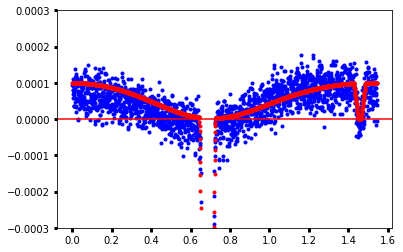

In [42]:
# Initial fit using Faigler's parameters (with my own T0)
plt.plot(binned_time, binned_flux, 'b.')

em = evmodel(binned_time, saved_ep, supersample_factor=10, exp_time=30./60./24.)
#sig = em.all_signals()
plt.plot(binned_time, sig, 'r.')

plt.ylim([-0.0003, 0.0003])
#plt.xlim([1.4, 1.6])
plt.axhline(0, color='red')

[0.7066812502235398, 4.524886877828054, 0.09683257918552035, 0.944]
(array([0.68497766, 4.64130284, 0.0956894 , 0.94017531]), array([2.09396621e-05, 1.48177625e-02, 7.81895474e-04, 1.66540080e-03]))
0.68508434


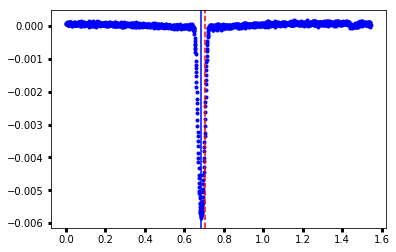

In [48]:
# Faigler's mid-transit time seems a little off. We fit a T0 value for the folded data below.
def fit_signal(time, T0, a, p, b):
    cur_ep = deepcopy(saved_ep)
    cur_ep.T0 = T0
    cur_ep.a = a
    cur_ep.p = p
    cur_ep.b = b
    
    em = evmodel(time, cur_ep, supersample_factor=10, exp_time=30./60./24.)
    
    return em.all_signals()

initial_guess = [Faigler_T0, saved_ep.a, saved_ep.p, saved_ep.b]
# popt, pcov = curve_fit(fit_signal, binned_time, binned_flux,
#                        p0=initial_guess, 
#                        bounds=([Faigler_T0 - 0.1, 2., 0., -1], [Faigler_T0 + 0.1, 5., 0.1, 1]))
print(initial_guess)
print(popt, np.sqrt(pcov.diagonal()))

# Update parameter
print(saved_ep.T0)
ep = deepcopy(saved_ep)
ep.T0 = popt[0]
ep.a = popt[1]
ep.p = popt[2]
ep.b = popt[3]

plt.plot(binned_time, binned_flux, 'b.')

# Faigler's T0 in read, the new one blue
plt.axvline(popt[0], color='blue')
plt.axvline(Faigler_T0, color='red', ls='--')

# Plotting residuals - Clearly not a perfect fit!
# plt.plot(binned_time, binned_flux - fit_signal(binned_time, *popt), 'b.')

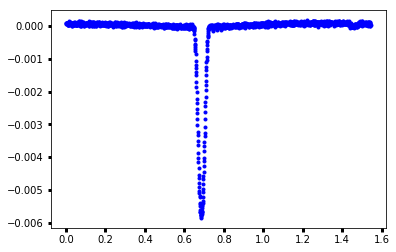

In [17]:
# Now re-retrieve data, masking out transit as data are filtered.
time, flux, filtered_time, filtered_flux = retreive_data(ep.per, num_periods=num_period, 
                                                         KIC=KIC, params=ep, fit_bottom=True)
folded_time = filtered_time % ep.per

binned_time, binned_flux, binned_err = bindata(folded_time, filtered_flux, binsize=binsize)
#plt.plot(folded_time, filtered_flux, 'b.')
plt.plot(binned_time, binned_flux, 'b.')

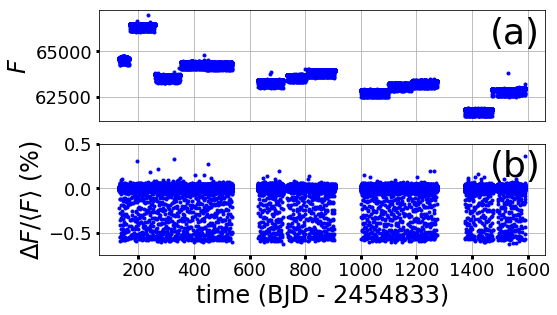

In [19]:
fig = plt.figure(figsize=(8, 4.5))

ax1 = fig.add_subplot(211)
ax1.tick_params(which='both', labelbottom=False, bottom=False)
ax1.tick_params(which='major', axis='y', labelsize=18)
ax1.grid(True)
ax1.set_ylabel("$F$", fontsize=24)
ax1.annotate("(a)", xy=(0.875, 0.7), xytext=(0.875, 0.7), fontsize=36, xycoords='axes fraction')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.grid(True)
ax2.set_xlabel("time (BJD - 2454833)", fontsize=24)
ax2.set_ylabel("$\Delta F/\\langle F \\rangle$ (%)", fontsize=24)
ax2.tick_params(which='both', labelsize=18)
ax2.annotate("(b)", xy=(0.875, 0.7), xytext=(0.875, 0.7), fontsize=36, xycoords='axes fraction')

# for q in range(0, 18):
KIC = 4570949
base_dir = "mastDownload/Kepler/"
time, flux, filtered_time, filtered_flux = retreive_data(per.to('day').value, params=ep)

ax1.plot(time, flux, 'b.')
ax2.plot(filtered_time, filtered_flux*100, 'b.')
ax2.set_ylim([-0.75, 0.5])

fig.savefig('Analysis_of_Kepler76b_data.jpg', dpi=500, bbox_inches='tight')

T0: 2454966.54887 +- 8e-05, Period: 1.5449288 +- 1e-07; BIC: 13.2113
a, b, c: 6.44186e-11 +- 4.21262e-10, 1.54493 +- 4.15539e-07, 132.004 +- 9.51374e-05; BIC: 19.6397


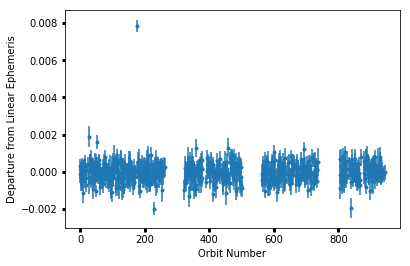

In [18]:
# Check transit ephemeris using ONLY the transit signal, not evilmc, just to speed up the calculation
def fit_signal(time, T0, supersample_factor=10, exp_time=30./60./24.):
    model = ft.MandelAgolLC(orbit="circular", ld="quad")

    # Set parameters
    model["per"] = ep.per
    model["i"] = inc
    model["a"] = ep.a
    model["T0"] = T0
    model["p"] = ep.p
    model["linLimb"] = ep.u[0]
    model["quadLimb"] = ep.u[1]
    model["b"] = 0.

    # Consider finite exposure time
    time_supersample = time
    if(supersample_factor > 1):
        time_offsets = np.linspace(-exp_time/2., exp_time/2., supersample_factor)
        time_supersample = (time_offsets + time.reshape(time.size, 1)).flatten()
    
    ret = model.evaluate(time_supersample)
    
    if(supersample_factor > 1):
        ret = np.mean(ret.reshape(-1, supersample_factor), axis=1)
        
    ret -= 1.
        
    return ret

def fit_line(x, m, b):
    return m*x + b

def fit_quad(x, a, b, c):
    return a*x**2 + b*x + c

# Collect each orbit, one at a time and fit mid-transit time
midtransit_times = np.array([])
midtransit_times_err = np.array([])

cur_orb = -1
num_orb = np.array([])
num_points_in_transit = np.array([])
ind = (filtered_time >= np.min(filtered_time)) & (filtered_time < np.min(filtered_time) + ep.per)
time = filtered_time[ind]
mn_time = np.min(time)

while(mn_time <= np.max(filtered_time)):
#while(mn_time <= np.min(filtered_time) + 100.*ep.per):
    
    ind = (filtered_time >= mn_time) & (filtered_time < mn_time + ep.per)
    mn_time += ep.per
    cur_orb += 1
    
    # Fewer than 70 points, and the mid-transit time fit is awful
    if(len(ind[ind]) <= 70):
        continue
       
    time = filtered_time[ind]
    flux = filtered_flux[ind]
    
    # Mask the transit and estimate uncertainties from standard deviation of remaining points
    folded_time = time % ep.per
    dur = transit_duration(ep)
    non_transit_ind = ~isInTransit(folded_time, T0, ep.per, 0.5*dur, boolOutput=True)
    err = np.ones_like(flux)*mad(flux[non_transit_ind])
    
    initial_guess = time[np.argmin(flux)]
    popt, pcov = curve_fit(fit_signal, time, flux, sigma=err, p0=initial_guess, 
                       bounds=(np.min(time), np.max(time)))
    
    # Calculate reduced chi-squared
    chisq = np.sum(((flux - fit_signal(time, *popt))/err)**2.)/(len(flux) - 1.)
    
    # Make sure there are at least three points in transit
    dur = transit_duration(ep)
    transit_ind = isInTransit(folded_time, popt[0], ep.per, 0.5*dur)
    if(len(time[transit_ind]) < 3):
        continue
    
    num_orb = np.append(num_orb, cur_orb)
    midtransit_times = np.append(midtransit_times, popt[0])
    midtransit_times_err = np.append(midtransit_times_err, np.sqrt(pcov[0]/chisq))

# Fit straight line to mid-transit times
lin_popt, lin_pcov = curve_fit(fit_line, num_orb, midtransit_times, sigma=midtransit_times_err)
# Calculate chi-squared and BIC
lin_fit = fit_line(num_orb, *lin_popt)
lin_chisq = np.sum((midtransit_times - lin_fit)/midtransit_times_err)**2./(len(num_orb) - 2.)
lin_BIC = lin_chisq + len(lin_popt)*np.log(len(num_orb))

# Rescale uncertainties to drive chi-squared to unity.
#   To shift T0 closer to the value reported in Faigler+ (2013), add one orbital period.
print("T0: %.5f +- %.1g, Period: %.7f +- %.1g; BIC: %g" % (lin_popt[1] + 2454833. + lin_popt[0], 
                                                           np.sqrt(lin_pcov[1,1]/lin_chisq), 
                                                           lin_popt[0], np.sqrt(lin_pcov[0,0]/lin_chisq), lin_BIC))

plt.errorbar(num_orb, midtransit_times - fit_line(num_orb, *lin_popt), midtransit_times_err, ls='', marker='.')
plt.xlabel('Orbit Number')
plt.ylabel('Departure from Linear Ephemeris')

# Fit quadratic to mid-transit times
quad_popt, quad_pcov = curve_fit(fit_quad, num_orb, midtransit_times, sigma=midtransit_times_err)
# Calculate chi-squared and BIC
quad_fit = fit_quad(num_orb, *quad_popt)
quad_chisq = np.sum((midtransit_times - quad_fit)/midtransit_times_err)**2./(len(num_orb) - 2.)
quad_BIC = quad_chisq + len(quad_popt)*np.log(len(num_orb))

# Rescale uncertainties to drive chi-squared to unity for quad model.
print("a, b, c: %g +- %g, %g +- %g, %g +- %g; BIC: %g" % (quad_popt[0], np.sqrt(quad_pcov[0,0]/quad_chisq),
                                                        quad_popt[1], np.sqrt(quad_pcov[1,1]/quad_chisq),
                                                        quad_popt[2], np.sqrt(quad_pcov[2,2]/quad_chisq),
                                                        quad_BIC))

# And finally check for any periodic signals -
#  https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
nout = 10000
min_freq = 1./np.min(midtransit_times[1:] - midtransit_times[0:-1])
max_freq = 1./(np.max(midtransit_times) - np.min(midtransit_times[0:-1]))
f = np.linspace(min_freq, max_freq, nout)
pgram = lombscargle(midtransit_times, midtransit_times - lin_fit, f)

# Largest peak barely above the other peaks, suggesting no periodicity
# plt.plot(f, pgram)

ep.per = lin_popt[0]
#ep.T0 = lin_popt[1]

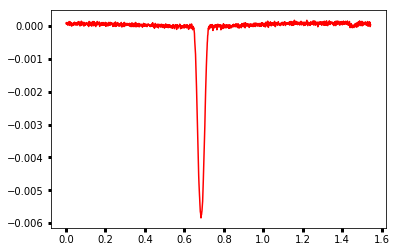

In [19]:
# Fit folded transit
time, flux, filtered_time, filtered_flux = retreive_data(ep.per, num_periods=num_period, 
                                                         KIC=KIC, params=ep)
folded_time = filtered_time % ep.per

binned_time, binned_flux, binned_err = bindata(folded_time, filtered_flux, binsize=binsize)
#plt.plot(folded_time, filtered_flux, 'b.')
plt.plot(binned_time, binned_flux, 'r')

In [32]:
def fit_transit(time, T0, inc, semi, p, supersample_factor=20, exp_time=30./60./24.):
    model = ft.MandelAgolLC(orbit="circular", ld="quad")

    # Set parameters
    model["per"] = ep.per
    model["i"] = inc
    model["a"] = semi
    model["T0"] = T0
    model["p"] = p
    model["linLimb"] = ep.u[0]
    model["quadLimb"] = ep.u[1]
    model["b"] = 0.

    # Consider finite exposure time
    time_supersample = time
    if(supersample_factor > 1):
        time_offsets = np.linspace(-exp_time/2., exp_time/2., supersample_factor)
        time_supersample = (time_offsets + time.reshape(time.size, 1)).flatten()
    
    ret = model.evaluate(time_supersample)
    
    if(supersample_factor > 1):
        ret = np.mean(ret.reshape(-1, supersample_factor), axis=1)
        
    ret -= 1.
        
    return ret

In [51]:
# Fit the EVIL-MC curve, holding constant the transit parameters
def fit_EVILMC(time, cur_q, cur_Kz, cur_F0, cur_Aplanet, cur_phase_shift):
    cur_ep = evparams(per=ep.per, a=ep.a, T0=ep.T0, p=ep.p, limb_dark="quadratic", b=ep.b, 
                      beta=ep.beta, Ts=Ts, Ws=[0.,0.,Omegas], u=coeffs,
                      q=cur_q, Kz=cur_Kz, F0=cur_F0, Aplanet=cur_Aplanet, phase_shift=cur_phase_shift)
    
    em = evmodel(time, cur_ep, supersample_factor=10, exp_time=30./60./24.)
    
    return em.all_signals()

[0.001590990389948875, 1.0273774132103083e-06, 5.04e-05, 5.04e-05, 0.02861111111111111]
(array([ 9.74648947e-03,  2.08464109e-06,  3.58181113e-05,  5.25429404e-05,
       -2.70447918e-02]), array([1.63534568e-03, 1.59607779e-04, 1.83162501e-06, 2.73593302e-05,
       4.82553932e-01]))
(<Quantity -8.61546196e-08>, <Quantity 3.34572143e-05>)


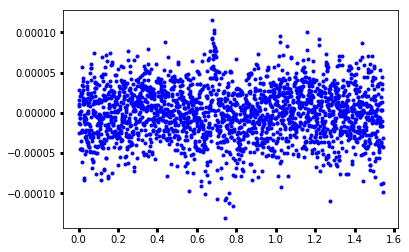

In [52]:
initial_guess = [ep.q, ep.Kz, ep.F0, ep.Aplanet, ep.phase_shift]

#%time popt, pcov = curve_fit(fit_EVILMC, binned_time, binned_flux, p0=initial_guess, bounds=([0., -1e-5, -100e-6, -100e-6, -1], [0.01, 1e-5, 100e-6, 100e-6, 1]))
print(initial_guess)
print(popt, np.sqrt(pcov.diagonal()))

# plt.plot(binned_time, binned_flux, 'b.')
# plt.plot(binned_time, fit_EVILMC(binned_time, *popt), 'r')

resid = binned_flux - fit_EVILMC(binned_time, *popt)
plt.plot(binned_time, resid, 'b.')
print(resid.mean(), resid.std())

In [28]:
# Save all notebook results so I don't have to re-run everything every time I open the notebook.
dill.dump_session('Analysis_of_Kepler76b.db')